# Scientific Paper Analysis

This notebook performs several actions to analyse (a) a 'seed' scientific paper, and (b) extract and download any references that can be found in that paper in arXiv.org. It can perform that step recursively, to build up a small graph of papers referred to by other papers. 

It uses a lot of heuristics and regular expressions to parse PDF files. Due to the huge variety of citation formats, it is very brittle. 



## Import dependencies, other preparation tasks

(Note: dependies should be first installed via requirements.txt).

In [75]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/liam/anaconda3/envs/patents-ai/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:

# Common Python libraries, used for regular expressions, file downloads and other things
import os, os.path
import re
import regex
import urllib, urllib.request, urllib.parse
# Parse arXiv API responses (in ATOM XML format)
import xml.etree.ElementTree as ET
import json

# Alternative to print()
from icecream import ic

# Used to extract PDF text
import textract

# Numpy and Pandas for data manipulation.
# All references stored in a Pandas DataFrame for easy analysis.
import numpy as np
import pandas as pd

# Not used yet - but helpful for simple machine learning tasks.
# Maybe helpful for text summarisation in particular.
# from transformers import pipeline

# Natural Language Toolkit - for tokenisation and basic linguistic analysis
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn

# Google Scholar wrapper - not that useful yet
from scholarly import scholarly

# Simple word cloud generator
from wordcloud import WordCloud

# For plotting
import matplotlib
# matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
%matplotlib inline 


The code below downloads a set of English language stopwords ('a', 'the' etc), and adds commonly occuring terms in PDFs, to remove further noise.

In [3]:
# Preparatory steps
nltk.download('stopwords')
full_stop_words = set(nltk.corpus.stopwords.words('english'))

full_stop_words.add('b')
full_stop_words.add('c')
full_stop_words.add('d')
full_stop_words.add('e')
full_stop_words.add('f')
full_stop_words.add('g')
full_stop_words.add('h')
full_stop_words.add('j')
full_stop_words.add('k')
full_stop_words.add('l')
full_stop_words.add('m')
full_stop_words.add('n')
full_stop_words.add('p')
full_stop_words.add('q')
full_stop_words.add('r')
full_stop_words.add('u')
full_stop_words.add('v')
full_stop_words.add('x')
full_stop_words.add('w')
full_stop_words.add('y')
full_stop_words.add('z')
full_stop_words.add('pp')
full_stop_words.add('et')
full_stop_words.add('al')
full_stop_words.add('ha')
full_stop_words.add('li')
full_stop_words.add('sij')
full_stop_words.add('arxiv')
full_stop_words.add('cid')
full_stop_words.add('jft')

[nltk_data] Downloading package stopwords to /Users/liam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reference Extraction and Parsing


A series of regular expression utilities for parsing and extraction whoe references from PDFs.



In [4]:
def load_text(file):
    return textract.process(file).decode('utf-8').replace('\n', ' ').replace('  ', ' ')

In [50]:
# Common functions for parsing references from plain text

def re_matches(text, regex):
    iterator = re.findall(regex, text)

    refs = []
    for match in iterator:
        refs.append(match) 

    return refs

def re_digit():
    return r'\[\d*\]\ '

def re_first_first():
    return r'(?:(?:\-?[A-Z]\.\ )+(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\,?\ ?)+)'

def re_first_first_multiple():
    return r'\ (?:' + re_first_first() +'+and\ )'

def re_first_last():
    # return r'(?:(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+)+\,\ (?:\-?[A-Z]\.\ ?)+)'
    return r'(?:(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+)(?:\ [A-Zvd][A-Za-z\-\u0080-\uFFFF]+)*\,\ (?:\-?[A-Z]\.\ ?)+)'

def re_first_last_multiple():
    return '(?:(?:' + re_first_last() +'\,\ )+' + re_first_last() + r'\,?\ and\ )?'

def re_full_first():
    return r'(?:(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\ )+(?:\-?[A-Z]\.?\ )*(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\,?\ ?)+)'

def re_year():
    return r'\(?(?:\d{4})\)?'

def re_trailing_digit():
    return r'(?:[\d\ \,]+\ )?'


def re_in_journal():
    return r'(?:(?:in)?\ [^\,]+\,\ )'

def re_pages():
    return r'(?:\ (?:pp\.\ )?\d+\-?\d+)?'


# Type 0
# Example: 2106.12139.pdf
def gen_refs_with_pages(text):
    r = ( 
        re_digit() 
        + r'('
        + re_first_first()  
        + r'[^\[\u201c-\u201f]*?\,?\ ' 
        + re_year() 
        + re_pages()
        + r')'
        + r'\.?'
        # + re_trailing_digit() 
        )
    regex = re.compile(r)
    return re_matches(text, regex)

# Type 1
# Example: Fashionista: A fashion-aware graphical system for exploring
def gen_refs_end_year_firstname_first(text):
    r = ( 
        re_digit() 
        + r'('
        # + re_first_first_multiple() 
        + re_first_first()  
        + r'[^\[\,]*?' 
        + re_in_journal()
        + r'[^\[]*?' 
        + re_year() 
        + r'\.'
        + r')'
        )
    regex = re.compile(r)    
    return re_matches(text, regex) 

# Type 2
# Example: Fashion-gen: The generative fashion dataset and challenge.pdf
def gen_refs_end_year_firstname_last(text):
    r = ( 
        r'('
        + re_first_last_multiple() 
        + re_first_last()  
        # + r'[^\[\.]*?\,?\ ' 
        + r'[^\[]*?\,?\ ' 
        # + r'[^\[\.]*?\,?\ ' # Work-around the grass paper problem
        # + re_pages()
        + re_year() 
        + r'\.'
        + r')'
        )
    regex = re.compile(r)    
    return re_matches(text, regex) 


# Type 3
# Example: A compact embedding for facial expression similarity.pdf
def gen_refs_with_pages_conjoined(text):
    r = ( 
        # re_digit() 
        r'('
        + re_first_first_multiple() 
        # + re_first_first()  
        # + r'\.[^\[\(]*?\,\ ' 
        # + re_year() 
        # + r'\.' 
        # + re_trailing_digit() 
        + r')'
        )
    regex = re.compile(r)
    return re_matches(text, regex)

# Type 4
# Example: Shapenet/ An information-rich 3d model repository.pdf
def gen_refs_expanded_name(text):
    r = ( 
        r'\[(?:\d+)\]\ '
        + r'('
        + re_full_first()  
        + r'[^\[]*?\,?\ ' 
        + re_year() 
        + r'\.?'
        + r')'
        )
    regex = re.compile(r)    
    return re_matches(text, regex) 


# Main reference 'generator'. Looks for a variety of reference patterns,
# and returns, along with the extracted references, a number that acts to flag
# the best internal reference parsing option to apply.
def gen_refs_multiple_pass(text):
    refs0 = gen_refs_with_pages(text)
    refs1 = gen_refs_end_year_firstname_first(text)
    refs2 = gen_refs_end_year_firstname_last(text)
    refs3 = gen_refs_with_pages_conjoined(text)
    # Too greedy?
    refs4 = gen_refs_expanded_name(text)

    lst = [refs0, refs1, refs2, refs3, refs4]
    lst_sorted = sorted(lst, key=len, reverse=True)
    refs = lst_sorted[0]
    ref_type = lst.index(refs)

    # Specific checks
    if ref_type == 0 and len(refs0) == len(refs1):
        refs = refs1
        ref_type = 1

    return refs, ref_type




Again, messy code to parse a reference string into parts (authors, title, journal / conference, publisher, volume, pages, year).

The type returned by gen_refs_multiple_pass() corresponds to the parse_refX function invoked here.

In [6]:
# Common functions for extracting references parts

# Makes a data frame object from a set of reference parameters
def make_dataframe(authors, title, journal, publisher, volume, year, pages, ref, source_file, source_title):
    return pd.DataFrame([[(', ').join(authors), title, journal, publisher, volume, year, pages, ref, source_file, source_title]], 
                        columns = ['authors', 'title', 'journal', 'publisher', 'volume', 'year', 'pages', 'full_ref', 'source_file', 'source_title'])

# Uses a general citation pattern to extract the authors, title, journal, volume, year, and pages
# The author pattern extracts individual authors. 
# The mapping object enables different orders in the regular expression.
def _parse_ref_internals(ref, citation_pattern, authors_pattern, mapping = {
        'first_authors': 0,
        'last_author': 1,
        'title': 2,
        'journal': 3,
        'publisher': 4,
        'volume': 5,
        'year': 6,
        'pages': 7
    }):
    all_authors = []
    title = ''
    journal = ''
    publisher = ''
    volume = ''
    year = ''
    pages = ''

    iterator = re.findall(citation_pattern, ref)
    for i in iterator:
        first_authors = i[mapping['first_authors']]
        last_author = i[mapping['last_author']].strip()
        title = i[mapping['title']]
        # Important to try to get the title right
        if title.find('.') >= 0:
            title_trap = re.compile(r'(?:[^\.]{,10}\.)*([^\.]+)\.')
            i2 = re.findall(title_trap, title)
            title = i2[0]
        title = title.replace('  ', ' ').replace('- ', '-').strip()
        journal = i[mapping['journal']]
        publisher = i[mapping['publisher']]
        volume = i[mapping['volume']]
        year = i[mapping['year']]
        pages = i[mapping['pages']]
        if first_authors != '':
            authors = re.findall(authors_pattern, first_authors)
            for a in authors:
                all_authors.append(a)
        all_authors.append(last_author)
    return all_authors, title, journal, publisher, volume, year, pages

# Parses a reference that follows this pattern:
# Y. Guo, Y. Liu, A. Oerlemans, S. Lao, S. Wu, M.S. Lew, Deep learning for visual understanding: A review, Neurocomputing, 187 (2016) 27-48
# From 2106.12139.pdf
# - Year before pages
# - All fields are comma-separated
# - Authors are not joined by a conjuntion
def parse_ref0(ref):
    citation_pattern = re.compile(
        r'((?:(?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+)\,\ )*)' # authors
        + r'((?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+))\,\ ' # last author
        + r'([^\,\.]*)\,\ ' # title
        + r'((?:[^\,]*)\,\ )?' # journal
        + r'((?:[^\,]*)\,\ )?' # publisher
        + r'(\d+\ )?' # volume
        + r'\(?(\d{4})\)?\,?\ ?' # year
        + r'(?:pp\.\ )?(\d+\-\d+)?'  # pages
        )
    authors_pattern = re.compile(
        r'((?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\ \-]+))')

    return _parse_ref_internals(ref, citation_pattern, authors_pattern)


# Parses a reference that follows this pattern:
def parse_ref1(ref):
    citation_pattern = re.compile(
        r'((?:(?:\-?[A-Z]\.\ ?)+(?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+)\,?\ )*and\ )?' 
        + r'((?:\-?[A-Zvd]\.\ ?)+(?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+))[\,\.]\ '  # last author
        + r'[\u0080-\uFFFF]?([^\,\.]*)[\,\.\u0080-\uFFFF]+' # title
        + r'(?:\ in\ )?([^\,\.]*)?' # journal
        + r'(?:\:?([^\,]*)\,\ )?' # publisher 
        + r'(?:vol\. (\d+)\ )?' # volume
        + r'(?:(?:pp\.\ )?(\d+\-?\d+)(?:\,?\ ?))?' # pages
        # + r'()'
        # + r'()'
        # + r'()'
        + r'.*(\d{4})\.' # years
        # + r'(\!)?'
        ) 
    authors_pattern = re.compile(r'(?:\-?[A-Z]\.\ ?)+[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+')

    return _parse_ref_internals(ref, citation_pattern, authors_pattern, mapping = {
        'first_authors': 0,
        'last_author': 1,
        'title': 2,
        'journal': 3,
        'publisher': 4,
        'volume': 5,
        'pages': 6,
        'year': 7
    })

# Parses a reference that follows this pattern:
def parse_ref2(ref):
    
    citation_pattern = re.compile(
        r'((?:(?:[A-Zvd][A-Za-z\-\ \u0080-\uFFFF]+)+\,\ (?:\-?[A-Z]\.\ ?)+(?:\,\ )?)*)(?:\,?\ and\ )?'
        + r'([A-Zvd][A-Za-za\-\ \u0080-\uFFFF]+\,\ (?:\-?[A-Z]\.\ ?)+)' 
        + r'([^\.]*)' # title
        + r'\.\ '
        + r'((?:[^\,]*))?'  # journal
        + r'(?:\,\ (.*(?:pp\.\ |d+\(d+\)\:)?\d+(?:\-\d*)?))?' # pages 
        + r'(\.\ (?:[^\,]*))?' # publisher
        + r'\,\ '
        + r'(\d{4})'
        + r'(\,\ \d+\ )?' # volume
        # + r'\.'
        )
    authors_pattern = re.compile(
        r'(?:[A-Zvd][A-Za-za\-\u0080-\uFFFF]+)+\,\ (?:\-?[A-Z]\.\ ?)+')

    return _parse_ref_internals(ref, citation_pattern, authors_pattern, mapping = {
        'first_authors': 0,
        'last_author': 1,
        'title': 2,
        'journal': 3,
        'pages': 4,
        'publisher': 5,
        'volume': 7,
        'year': 6
    })

def parse_ref3(ref):
    citation_pattern = re.compile(
        r'((?:(?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\ \-]+\,\ ))*)and\ ((?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\ \-]+\.))?' 
        + r'([^\,]*)\,\ ([^\,]*)\,\ (?:([^\,]*)\,\ )?' 
        + r'(?:(\d+)\ )?' # volume
        + r'\(?(\d{4})\)?\,?\ ?' 
        + r'(?:pp\.\ )?(\d+\-?\d+)?')
    authors_pattern = re.compile(r'((?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\ \-]+))')

    return _parse_ref_internals(ref, citation_pattern, authors_pattern)


def parse_ref4(ref):
    citation_pattern = re.compile(
        r'((?:(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\ )+(?:\-?[A-Z]\.?\ )*(?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+)\,?\ )*)and\ ' 
        + r'((?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\ )+(?:\-?[A-Zvd]\.?\ )*(?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+))[\,\.]\ (?:et\ al\.\ )?'  # last author
        + r'([^\.]*)\.\ ' # title
        + r'(?:In\ )?([^\,]*)(?:[\,\.]\ )' # journal
        + r'(\d+(?:\(\d+\))?\:)?' # volume
        + r'(?:pages\ )?(\d+[\–|\u2014]\d+)?' # pages
        + r'([^\,\.]*\,\ )?' # publisher 
        + r'[\ a-zA-Z]*(\d{4})\.' # year
        # + r'(\!)?'
        # + r'(\!)?'
        # + r'(\!)?'
        # + r'(\!)?'
        ) 
    authors_pattern = re.compile(r'(?:[A-Zvd][A-Za-z\-\u0080-\uFFFF]+\ )+(?:\-?[A-Z]\.\ )*[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+')

    return _parse_ref_internals(ref, citation_pattern, authors_pattern, mapping = {
        'first_authors': 0,
        'last_author': 1,
        'title': 2,
        'journal': 3,
        'volume': 4,
        'pages': 5,
        'publisher': 6,
        'year': 7
    })

def parse_ref(ref, ref_type):
    if ref_type == 0:
        return parse_ref0(ref)
    elif ref_type == 1:
        return parse_ref1(ref)
    elif ref_type == 2:
        return parse_ref2(ref)
    elif ref_type == 3:
        return parse_ref3(ref)
    elif ref_type == 4:
        return parse_ref4(ref)
    else:
        return parse_ref0(ref)


def parse_ref_and_makedataframe(ref, ref_type, source_file, source_title):
    authors, title, journal, publisher, volume, year, pages = parse_ref(ref, ref_type)
    # ic(title)
    return make_dataframe(authors, title, journal, publisher, volume, year, pages, ref, source_file, source_title)




A set of utility functions to help with processing PDF and analysing text.

In [7]:
# Other utility functions

def get_lemma(word):
    return WordNetLemmatizer().lemmatize(word)

def remove_set_from_dict(s, d):
    for t in s:
        if t in d:
            del d[t]
    return d
    
def word_frequencies(text):
    words = re.findall('[A-Za-z][A-Za-z0-9]*', text)
    frequencies = {}
    for w in words:
        w = w.lower()
        w = get_lemma(w)
        if w not in full_stop_words:
            if w in frequencies:
                frequencies[w] += 1
            else:
                frequencies[w] = 1
    return frequencies

def word_frequencies_dist(text, frequencies):
    words = re.findall('[A-Za-z][A-Za-z0-9]*', text)
    for w in words:
        w = w.lower()
        w = get_lemma(w)
        if w not in full_stop_words:
            if w in frequencies:
                frequencies[w] += 1
            else:
                frequencies[w] = 1
    return frequencies


def wc(freqs, file_name):
    wordcloud = WordCloud(background_color="white", width=600, height=600, max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    #wordcloud.generate(long_string)
    wordcloud.generate_from_frequencies(freqs)
    wordcloud.to_file(f'data/word-cloud-{file_name}.png')
    wordcloud.to_image()


def arxiv_results(title):
    t =  urllib.parse.quote_plus(title)
    url = 'http://export.arxiv.org/api/query?search_query=all:'+t+'&start=0&max_results=1'
    data = urllib.request.urlopen(url)
    return data.read().decode('utf-8')


def make_up_file_name(file_name, directory):
    return os.path.join(directory, file_name + '.pdf')


def extract_and_save_pdf_from_atom(atom_xml, title, title_no_colon, title_stem, directory, pass_through=False):
    root = ET.fromstring(atom_xml)
    for e in root.findall('{http://www.w3.org/2005/Atom}entry'):
        t = e.find('{http://www.w3.org/2005/Atom}title')
        link = e.find('{http://www.w3.org/2005/Atom}link')
        if t.text.lower().find(title_stem.lower()) == 0:
            for link in e.findall('{http://www.w3.org/2005/Atom}link'):
                # Title must match and link must be a pdf
                if 'type' in link.attrib and link.attrib['type'] == 'application/pdf':
                    u  = link.attrib['href']
                    # ic(u, title, directory)
                    if not pass_through:
                        urllib.request.urlretrieve(u, 
                            make_up_file_name(title, directory))


def test_element(atom_xml):
    try:
        root = ET.fromstring(atom_xml)
        entry = root.find('{http://www.w3.org/2005/Atom}entry')
        if entry is not None:
            return True
        else:
            return False
    except ET.ParseError as e:
        ic(e)


# Attempt to locate references on Arxiv, and save any found files as pdfs
def download_from_arxiv(titles, directory):
    counter = 0
    for title in titles:

        # Check if the string is empty
        if len(title) == 0:
            continue

        f = make_up_file_name(title, directory)
        
        counter = counter + 1

        # If the file already exists, 
        if not os.path.isfile(f):
            
            # Search for the title on Arxiv
            r = arxiv_results(title)

            # Create abridged versions
            title_stem = title
            title_no_colon = title
            if title.find(':') > -1:
                title_stem = title[:title.index(':')]
                title_no_colon = title[:title.index(':')] + title[title.index(':')+1:]
            
            # Did we find a result?
            has_entry = test_element(r)

            # Remove the semi-colon - seems to confuse Arxiv API
            if not has_entry:
                r = arxiv_results(title_no_colon)
                has_entry = test_element(r)

            # Remove everything after the semi-colon
            if not has_entry:
                r = arxiv_results(title_stem)
                has_entry = test_element(r)

            ic(counter, title)
            if has_entry:
                extract_and_save_pdf_from_atom(r, title, title_no_colon, title_stem, directory, False)


def top_dist(freqs, n):
    counter = 0
    for w in sorted(freqs, key = freqs.get, reverse = True):
        counter = counter + 1
        print(w, freqs[w])
        if counter == n:
            break

In [17]:


# Extract word frequencies and references from the pdfs.
def extract_frequences_and_references(d, freqs, references):

    all_freqs = {**freqs}
    all_references = references.copy()
    counter  = 0 
    for file in os.listdir(d):

        # if file.endswith("Virtualhome: Simulating household activities via programs.pdf"):
        # if file.endswith("Training deep nets with sublinear memory cost.pdf"):
        # if file.endswith("A compact embedding for facial expression similarity.pdf"):
        # if file.endswith("Training deep nets with sublinear memory cost.pdf"):
        # if file.endswith("Grass: Generative recursive autoencoders for shape structures.pdf"):
        # if file.endswith(".pdf") and file.find('Deepfashion') == -1 and file.find('Predictive and generative') == -1 and file.find('Virtualhome') == -1:
        # if file.find("Whittlesearch") >= 0:
        if file.endswith(".pdf") and file.find('Deepfashion') == -1 and file.find('Grass') != 0:
            counter = counter + 1
            f = os.path.join(d, file)
            source_title = file.split('.')[0]
            ic(f)
            try:
                text_local = load_text(f)
                all_texts[source_title] = text_local
                all_freqs = word_frequencies_dist(text_local, all_freqs)
                refs_local, ref_type  = gen_refs_multiple_pass(text_local)

                ic(counter, ref_type, len(refs_local))
                counter = 0
                for r in refs_local:
                    counter = counter + 1

                    # if counter > 3:
                    #     break

                    # authors, title, journal, publisher, volume, year, pages = parse_ref1(r)
                    # ic(authors)
                    # ic(title)
                    # ic(journal)
                    # ic(publisher)
                    # ic(volume)
                    # ic(pages)
                    # ic(year)

                    all_references = all_references.append(parse_ref_and_makedataframe(r, ref_type, f, source_title))
                    # ic(len(all_references['title']))

            except Exception as e:
                # ic(e)
                pass
        
    return all_freqs, all_references


In [9]:

# Save frequencies as JSON
def frequencies_save(file_name, frequencies):
    with open(file_name, 'w') as fp:
        json.dump(frequencies, fp)

# Load frequencies from JSON file
def frequencies_load(file_name):
    # JSON file
    f = open(file_name, "r")
    
    # Reading from file
    frequencies = json.loads(f.read())
    
    # Closing file
    f.close()

    return frequencies


# Extract word frequencies and references from the pdfs.
def extract_text(d):
    texts = {}
    for file in os.listdir(d):
        f = os.path.join(d, file)
        source_title = file.split('.')[0]
        if file.endswith(".pdf"):
            try:
                text_local = load_text(f)
                r = re.compile(r'(References\ [A-Z\[].{10})')
                iterator = re.finditer(r, text_local)
                l = len(text_local)
                last_instance = -1
                for i in iterator:
                    test = i.start()
                    ic(i)
                    if test > last_instance:
                        last_instance = test
                if last_instance > 0:
                    text_local = text_local[:last_instance]
                ic(last_instance, l)
                texts[source_title] = text_local
            except Exception as e:
                # ic(e)
                pass
    return texts


## Processing files

The code below analyses frequencies and extracts references for a 'seed' paper.


Variables for analysis

In [25]:

# Store texts for 
all_texts = {}

# Variables for the seed file
frequencies_seed = {}
references_seed = pd.DataFrame(columns = ['authors', 'title', 'journal', 'publisher', 'volume', 'year', 'pages', 'full_ref', 'source_file', 'source_title'])
# Variables for the 1st layer
frequencies_1layer = {}
references_1layer = {}
# Variables for the 2nd layer
frequencies_2layer = {}
references_2layer = {}
# Variables for the 3rd layer
frequencies_3layer = {}
references_3layer = {}


In [26]:


directory1 = './refs/download/1'
directory2 = './refs/download/2'
directory3 = './refs/download/3'



Load the seed file.

Both file name and title must be supplied, and the PDF file downloaded to the 'refs' directory first.

In [27]:

# Seed file Input
file_name = '2106.12139.pdf'
title = 'PatentNet: A Large-Scale Incomplete Multiview, Multimodal, Multilabel Industrial Goods Image Database'

# Extract the text
text = load_text('./refs/'+file_name)
# all_texts[title] = text

# Obtain word frequencies
frequencies_seed = word_frequencies(text)

# Set up a references dataframe
references_seed = references_seed.append(make_dataframe(['Fangyuan Leia, Da Huanga, Jianjian Jianga, Ruijun Ma, Senhong Wang, Jiangzhong Cao, Yusen Lin, Qingyun Dai'], 
            title, 'arXiv', '', '', '2021', '', '', file_name, ''))

# Extract the references and add to the dataframe
refs, ref_type = gen_refs_multiple_pass(text)
for r in refs:
    references_seed = references_seed.append(parse_ref_and_makedataframe(r, ref_type, file_name, title))

# Save references to a csv
references_seed.to_csv('data/references.csv')
frequencies_save('data/frequencies_seed.json', frequencies_seed)



### 1st Layer of references

In [308]:

# Downloads files from references, where they can be found.
download_from_arxiv(references_seed['title'], directory1)

ic| counter: 1
    title: ('PatentNet: A Large-Scale Incomplete Multiview, Multimodal, Multilabel '
            'Industrial Goods Image Database')
ic| counter: 2
    title: 'Deep learning for visual understanding: A review'
ic| counter: 3
    title: ('Deep convolutional neural networks for image classification: A comprehensive '
            'review')
ic| counter: 4
    title: ('Deepfashion: Powering robust clothes recognition and retrieval with rich '
            'annotations')
ic| counter: 5
    title: '3d shapenets: A deep representation for volumetric shapes'
ic| counter: 6
    title: ('Seeing 3d chairs: exemplar part-based 2d-3d alignment using a large dataset '
            'of cad models')
ic| counter: 7
    title: 'Benchmark Datasets for Fault Detection and Classification in Sensor Data'
ic| counter: 8
    title: 'A style-based generator architecture for generative adversarial networks'
ic| counter: 9
    title: 'A compact embedding for facial expression similarity'
ic| counter: 

In [48]:
frequencies_1layer, references_1layer = extract_frequences_and_references(directory1, frequencies_seed, references_seed)
references_1layer.to_csv('data/references_1layer.csv')
frequencies_save('data/frequencies_1layer.json', frequencies_1layer)


ic| f: ('./refs/download/1/Fashionista: A fashion-aware graphical system for '
        'exploring visually similar items.pdf')
ic| counter: 1, ref_type: 1, len(refs_local): 7
ic| f: ('./refs/download/1/Fashion-gen: The generative fashion dataset and '
        'challenge.pdf')
ic| counter: 8, ref_type: 2, len(refs_local): 31
ic| f: ('./refs/download/1/Central similarity quantization for efficient image and '
        'video retrieval.pdf')
ic| counter: 32, ref_type: 3, len(refs_local): 44
ic| f: './refs/download/1/Doubly Aligned Incomplete Multi-view Clustering.pdf'
ic| counter: 45, ref_type: 1, len(refs_local): 0
ic| f: ('./refs/download/1/Efficientnet: Rethinking model scaling for convolutional '
        'neural networks.pdf')
ic| counter: 1, ref_type: 2, len(refs_local): 52
ic| f: './refs/download/1/A compact embedding for facial expression similarity.pdf'
ic| counter: 53, ref_type: 3, len(refs_local): 50
ic| f: ('./refs/download/1/Fashion-mnist: a novel image dataset for benchmarking

In [49]:

# Check length of references looks reasonable
ic(len(references_1layer['title']))


ic| len(references_1layer['title']): 338


338

### 2nd layer of references

In [311]:

titles_1layer = references_1layer['title']   
download_from_arxiv(titles_1layer, directory2)

ic| counter: 2
    title: 'Deep learning for visual understanding: A review'
ic| counter: 3
    title: ('Deep convolutional neural networks for image classification: A comprehensive '
            'review')
ic| counter: 5
    title: '3d shapenets: A deep representation for volumetric shapes'
ic| counter: 6
    title: ('Seeing 3d chairs: exemplar part-based 2d-3d alignment using a large dataset '
            'of cad models')
ic| counter: 7
    title: 'Benchmark Datasets for Fault Detection and Classification in Sensor Data'
ic| counter: 8
    title: 'A style-based generator architecture for generative adversarial networks'
ic| counter: 10
    title: ('Partnet: A large-scale benchmark for fine-grained and hierarchical '
            'part-level 3d object understanding')
ic| counter: 11
    title: '3d object representations for fine-grained categorization'
ic| counter: 13
    title: 'Fashionai: A hierarchical dataset for fashion understanding'
ic| counter: 16
    title: 'Very deep convoluti

In [40]:

# 2nd level analysis
frequencies_2layer, references_2layer = extract_frequences_and_references(directory2, frequencies_seed, references_seed)
references_2layer.to_csv('data/references_2layer.csv')
frequencies_save('data/frequencies_2layer.json', frequencies_2layer)


ic| f: ('./refs/download/2/Fashionista: A fashion-aware graphical system for '
        'exploring visually similar items.pdf')
ic| counter: 1, ref_type: 1, len(refs_local): 7
ic| f: ('./refs/download/2/Fashion-gen: The generative fashion dataset and '
        'challenge.pdf')
ic| counter: 8, ref_type: 1, len(refs_local): 0
ic| f: ('./refs/download/2/Xception: Deep learning with depthwise separable '
        'convolutions.pdf')
ic| counter: 1, ref_type: 1, len(refs_local): 23
ic| f: './refs/download/2/PointCNN: Convolution on X -transformed points.pdf'
ic| f: ('./refs/download/2/Proxylessnas: Direct neural architecture search on target '
        'task and hardware.pdf')
ic| counter: 25, ref_type: 1, len(refs_local): 0
ic| f: ('./refs/download/2/Grass: Generative recursive autoencoders for shape '
        'structures.pdf')
ic| f: ('./refs/download/2/Resnet with one-neuron hidden layers is a universal '
        'approximator.pdf')
ic| f: ('./refs/download/2/FaceNet: A In uniﬁed embedding 

In [51]:

# Check length of references looks reasonable
ic(len(references_2layer['title']))


ic| len(references_2layer['title']): 1812


1812

### 3rd Layer  of references

In [322]:
# 3rd pass

# Downloads files from references, where they can be found.
download_from_arxiv(references_2layer['title'], directory3)

ic| counter: 2
    title: 'Deep learning for visual understanding: A review'
ic| counter: 3
    title: ('Deep convolutional neural networks for image classification: A comprehensive '
            'review')
ic| counter: 5
    title: '3d shapenets: A deep representation for volumetric shapes'
ic| counter: 6
    title: ('Seeing 3d chairs: exemplar part-based 2d-3d alignment using a large dataset '
            'of cad models')
ic| counter: 7
    title: 'Benchmark Datasets for Fault Detection and Classification in Sensor Data'
ic| counter: 8
    title: 'A style-based generator architecture for generative adversarial networks'
ic| counter: 11
    title: '3d object representations for fine-grained categorization'
ic| counter: 13
    title: 'Fashionai: A hierarchical dataset for fashion understanding'
ic| counter: 16
    title: 'Very deep convolutional networks for large-scale image recognition'
ic| counter: 17, title: 'Going deeper with convolutions'
ic| counter: 18, title: 'Deep residual lea

In [35]:

# 3rd level analysis
frequencies_3layer, references_3layer = extract_frequences_and_references(directory3, frequencies_seed, references_seed)
references_3layer.to_csv('data/references_3layer.csv')
frequencies_save('data/frequencies_3layer.json', frequencies_3layer)


ic| f: ('./refs/download/3/Fashionista: A fashion-aware graphical system for '
        'exploring visually similar items.pdf')
ic| counter: 1, ref_type: 1, len(refs_local): 7
ic| f: './refs/download/3/HoME: a arXiv preprint Household Multimodal Environment.pdf'
ic| counter: 8, ref_type: 4, len(refs_local): 37
ic| f: ('./refs/download/3/Fashion-gen: The generative fashion dataset and '
        'challenge.pdf')
ic| counter: 38, ref_type: 2, len(refs_local): 31
ic| f: ('./refs/download/3/Xception: Deep learning with depthwise separable '
        'convolutions.pdf')
ic| counter: 32, ref_type: 1, len(refs_local): 23
ic| f: './refs/download/3/Training deep nets with sublinear memory cost.pdf'
ic| counter: 24, ref_type: 4, len(refs_local): 19
ic| f: ('./refs/download/3/Faster r-cnn: Towards real-time object detection with '
        'region proposal networks.pdf')
ic| counter: 20, ref_type: 3, len(refs_local): 39
ic| f: ('./refs/download/3/Vote3deep: Fast object detection in 3d point clouds us

### Load Data from CSVs

Optional - bypasses previous (time-consuming) steps, but doesn't contain frequencies.

In [237]:
# Load existing data
references_seed = pd.read_csv('data/references.csv')
references_1layer = pd.read_csv('data/references_1layer.csv')
references_2layer = pd.read_csv('data/references_2layer.csv')
references_3layer = pd.read_csv('data/references_3layer.csv')

references_seed.loc[references_seed['source_title'].isnull(),'source_title'] = ''
references_seed.loc[references_seed['title'].isnull(),'title'] = ''
references_1layer.loc[references_1layer['source_title'].isnull(),'source_title'] = ''
references_1layer.loc[references_1layer['title'].isnull(),'title'] = ''
references_2layer.loc[references_2layer['source_title'].isnull(),'source_title'] = ''
references_2layer.loc[references_2layer['title'].isnull(),'title'] = ''
references_3layer.loc[references_3layer['source_title'].isnull(),'source_title'] = ''
references_3layer.loc[references_3layer['title'].isnull(),'title'] = ''

In [ ]:
frequencies_seed = frequencies_load('data/frequencies_seed.json')
frequencies_1layer = frequencies_load('data/frequencies_1layer.json')
frequencies_2layer = frequencies_load('data/frequencies_2layer.json')
frequencies_3layer = frequencies_load('data/frequencies_3layer.json')

### Text Extraction

In [58]:
texts = extract_text(directory3)
ic(len(texts.keys()))
# for t in texts.keys():
#     ic(t)

ic| last_instance: -1, l: 19921
ic| i: <re.Match object; span=(13831, 13853), match='References [1] Kelly F'>
ic| last_instance: 13831, l: 21097
ic| i: <re.Match object; span=(21215, 21237), match='References Y. Generati'>
ic| last_instance: 21215, l: 31242
ic| i: <re.Match object; span=(24749, 24771), match='References [1] M. Abad'>
ic| last_instance: 24749, l: 28937
ic| i: <re.Match object; span=(31879, 31901), match='References [1] Martı́n'>
ic| last_instance: 31879, l: 37944
ic| i: <re.Match object; span=(16810, 16832), match='References Our design '>
ic| last_instance: 16810, l: 64807
ic| last_instance: -1, l: 52433
ic| last_instance: -1, l: 38800
ic| i: <re.Match object; span=(37438, 37460), match='References [1] Y. Beng'>
ic| last_instance: 37438, l: 40983
ic| i: <re.Match object; span=(33610, 33632), match='References [1] Olga Ru'>
ic| last_instance: 33610, l: 52590
ic| last_instance: -1, l: 64210
ic| i: <re.Match object; span=(35729, 35751), match='References [1] Y. Cao,'>
ic|

184

# Language processing

## Totals

In [74]:
print("Seed paper references: ", len(references_seed['title']))
print("Seed paper references (unique): ", len(pd.unique(references_seed['title'])))
print("Seed paper references (unique): ", round(len(pd.unique(references_seed['title'])) / len(references_seed['title']), 2))
print("---")
print("1st level references: ", len(references_1layer['title']))
print("1st level references (unique): ", len(pd.unique(references_1layer['title'])))
print("1st level references (ratio): ", round(len(pd.unique(references_1layer['title'])) / len(references_1layer['title']), 2))
print("---")
print("2nd level references: ", len(references_2layer['title']))
print("2nd level references (unique): ", len(pd.unique(references_2layer['title'])))
print("2nd level references (ratio): ", round(len(pd.unique(references_2layer['title'])) / len(references_2layer['title']), 2))
print("---")
print("3rd level references: ", len(references_3layer['title']))
print("3rd level references (unique): ", len(pd.unique(references_3layer['title'])))
print("3rd level references (ratio): ", round(len(pd.unique(references_3layer['title'])) / len(references_3layer['title']), 2))

Seed paper references:  32
Seed paper references (unique):  30
Seed paper references (unique):  0.94
---
1st level references:  338
1st level references (unique):  155
1st level references (ratio):  0.46
---
2nd level references:  1812
2nd level references (unique):  536
2nd level references (ratio):  0.3
---
3rd level references:  5267
3rd level references (unique):  1586
3rd level references (ratio):  0.3


/Users/liam/anaconda3/envs/patents-ai/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Frequencies

In [375]:
# Generate the word cloud from the seed file frequencies.
wc(frequencies_seed, 'frequencies_seed')

# Generate the word cloud from frequencies of all 1st downloaded files.
wc(frequencies_1layer, 'frequencies_1layer')

# Generate the word cloud from frequencies of all 2nd level downloaded files.
wc(frequencies_2layer, 'frequencies_2layer')

# Generate the word cloud from frequencies of all 3rd level downloaded files.
wc(frequencies_3layer, 'frequencies_3layer')

In [234]:
ic("Seed file word frequencies")
top_dist(frequencies_seed, 10)

ic| 'Seed file word frequencies'


image 95
industrial 92
good 81
view 69
patentnet 61
dataset 40
classification 29
incomplete 26
retrieval 24
large 23


In [235]:
ic("1st level word frequencies")
top_dist(frequencies_1layer, 10)


ic| '1st level word frequencies'


image 520
hash 292
dataset 275
view 275
learning 263
method 261
part 255
network 229
data 228
model 205


In [52]:
ic("2nd level word frequencies")
top_dist(frequencies_2layer, 10)


ic| '2nd level word frequencies'


network 3325
image 2244
model 2045
learning 1762
point 1734
layer 1695
training 1510
feature 1313
object 1248
result 1245


In [77]:
ic("3rd level word frequencies")
top_dist(frequencies_3layer, 10)


ic| '3rd level word frequencies'


image 7267
network 7235
model 6243
layer 4586
training 4335
learning 4216
feature 3797
object 3624
data 3303
using 3298


## References by Year

In [79]:
references_3layer.reset_index(drop=True, inplace=True)
empty_years = references_3layer[references_3layer['year'] == ''].index
nan_years = references_3layer[references_3layer['year'].isnull()].index
all_refs_uniq = references_3layer.drop(empty_years).drop(nan_years).drop_duplicates('title')



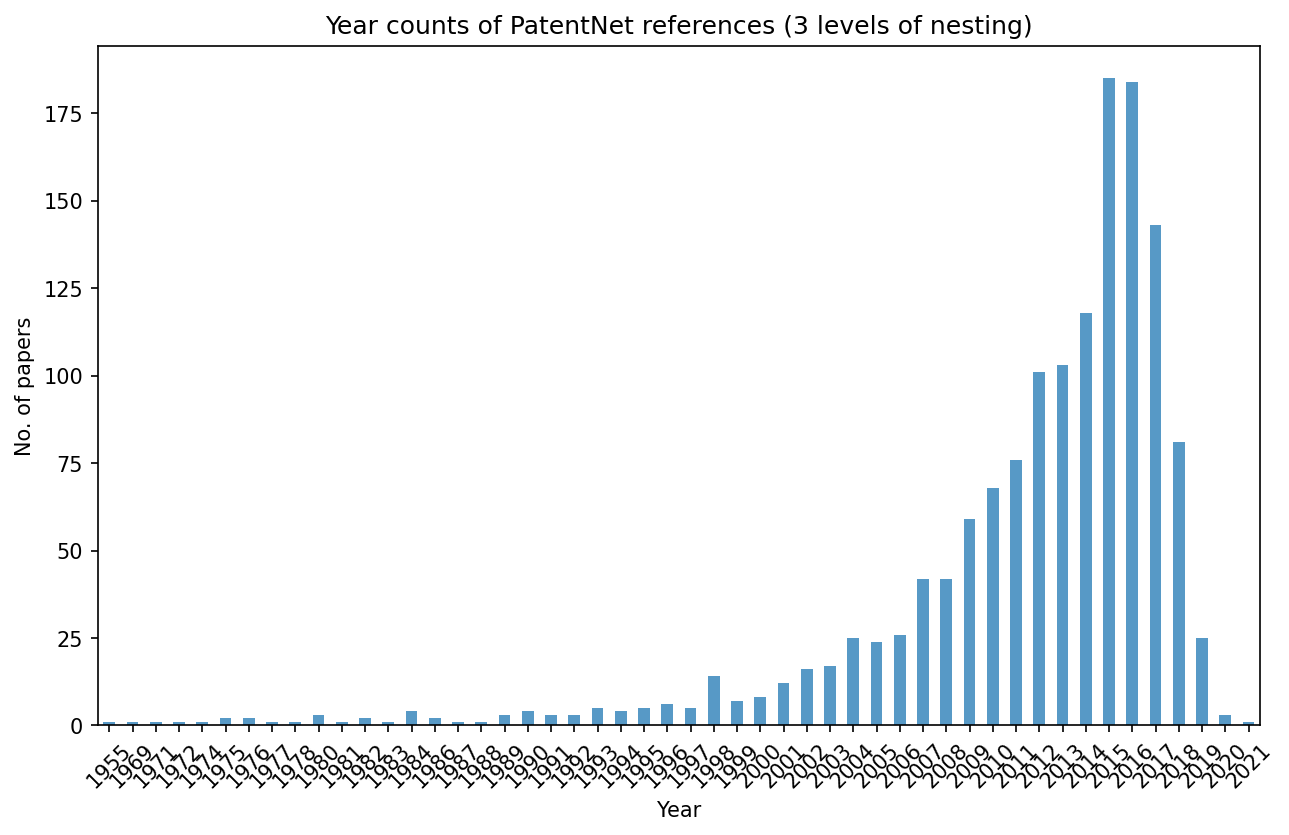

In [80]:
all_refs_uniq.loc[:,'year'] = all_refs_uniq.loc[:, 'year'].astype(int)

year_counts = all_refs_uniq.query('year > 1900 and year < 2022').loc[:,'year'].value_counts().sort_index()
fig, ax = plt.subplots(facecolor='white')
fig.set_size_inches(10, 6)
fig.set_dpi(150)
year_counts.plot(kind='bar',alpha=0.75, rot=45, ax=ax)
plt.title("Year counts of PatentNet references (3 levels of nesting)")
plt.ylabel('No. of papers')
plt.xlabel('Year')
# ax.set_facecolor("white")
plt.savefig('data/output.png', facecolor=fig.get_facecolor(), bbox_inches='tight')



In [83]:
all_refs_uniq.query('year > 1900').sort_values('year')

,authors,title,journal,publisher,volume,year,pages,full_ref,source_file,source_title
2131,H. W. Kuhn,The hungarian method for the assignment problem,Naval research logistics quarterly,,,1955,,H. W. Kuhn. The hungarian method for the assig...,./refs/download/3/Partnet: A large-scale bench...,Partnet: A large-scale benchmark for fine-grai...
2647,"R. A. Schumacker, B. Brand, M. G. Gilliland, W...",Study for applying computer-generated images t...,Technical report,,,1969,,"R. A. Schumacker, B. Brand, M. G. Gilliland, a...",./refs/download/3/Escape from Cells: Deep KdNe...,Escape from Cells: Deep KdNetworks for The Rec...
2212,P. Ekman,Universals and cultural differences in facial ...,"in: Nebraska Symposium on Motivation,","Lincoln University of Nebraska Press,",,1971,,"P. Ekman, Universals and cultural differences ...",./refs/download/3/: Web-based database for fac...,: Web-based database for facial expression ana...
4739,T. Winograd,Understanding Natural Language,Academic Press,,,1972,,T. Winograd. Understanding Natural Language. A...,./refs/download/3/Inferring and executing prog...,Inferring and executing programs for visual re...
3094,H. Einhorn,Expert judgment: Some necessary conditions and...,Journal of Applied Psychology,,,1974,,H. Einhorn. Expert judgment: Some necessary co...,./refs/download/3/From amateurs to connoisseur...,From amateurs to connoisseurs: modeling the ev...
...,...,...,...,...,...,...,...,...,...,...
4297,"S. Zheng, M.-M. Cheng, J. Warrell, P. Sturgess...",Dense semantic image segmentation with objects...,In CVPR,,,3221,,"S. Zheng, M.-M. Cheng, J. Warrell, P. Sturgess...",./refs/download/3/Material recognition in the ...,Material recognition in the wild with the mate...
1696,"T. Wang, D. J. Wu, A. Coates, A. Y. Ng",End-to-end text recognition with convolutional...,In Pattern Recognition (ICPR),,,3308,2012,"T. Wang, D. J. Wu, A. Coates, and A. Y. Ng. En...",./refs/download/3/Speeding up convolutional ne...,Speeding up convolutional neural networks with...
4301,"M. Cimpoi, S. Maji, I. Kokkinos, S. Mohamed, A...",Describing textures in the wild,In CVPR,,,3613,,"M. Cimpoi, S. Maji, I. Kokkinos, S. Mohamed, a...",./refs/download/3/Material recognition in the ...,Material recognition in the wild with the mate...
2338,"D. Ciregan, U. Meier, J. Schmidhuber",Multi-column deep neural networks for image cl...,In Computer Vision and Pattern Recognition (C...,,,3649,2012,"D. Ciregan, U. Meier, and J. Schmidhuber. Mult...",./refs/download/3/SO-Net: Self-organizing netw...,SO-Net: Self-organizing network for point clou...


## Network Analysis

In [220]:
# !pip install networkx 
# !pip install PyVis
# !pip install scipy

/Users/liam/anaconda3/envs/patents-ai/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [388]:
#Data clean-up - remove title hyphens
# references_seed['title'] = references['title'].str.replace('- ', '')
# all_references['title'] = all_references['title'].str.replace('- ', '')
# all_references2['title'] = all_references2['title'].str.replace('- ', '')
# all_references3['title'] = all_references3['title'].str.replace('- ', '')


In [149]:
references_seed.loc[references_seed['source_title'].isnull(),'source_title'] = ''

/Users/liam/anaconda3/envs/patents-ai/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [210]:
import networkx as nx

#load pandas df as networkx graph
G_seed = nx.from_pandas_edgelist(references_seed, 'source_title', 'title', create_using=nx.DiGraph())
G_1layer = nx.from_pandas_edgelist(references_1layer, 'source_title', 'title', create_using=nx.DiGraph())
# G_2layer = nx.from_pandas_edgelist(references_2layer, 'source_title', 'title', create_using=nx.DiGraph())
# G_3layer = nx.from_pandas_edgelist(references_3layer, 'source_title', 'title', create_using=nx.DiGraph())


/Users/liam/anaconda3/envs/patents-ai/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/Users/liam/anaconda3/envs/patents-ai/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



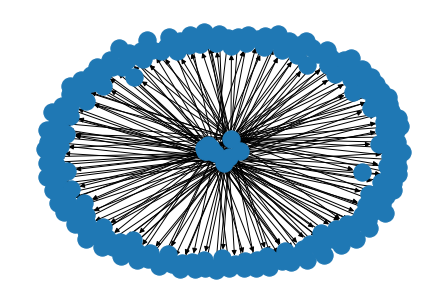

In [212]:
nx.draw(G_1layer)

In [215]:
# from https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259

#import pyvis
from pyvis.network import Network
# create vis network
net = Network(notebook=False, height='750px', width='100%', bgcolor='#222222', font_color='white')
# load the networkx graph
net.from_nx(G_1layer)
# show
net.show("references-1lG_1layer.html")

/Users/liam/anaconda3/envs/patents-ai/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Topic modellling

### BERTTopic

In [46]:
from sklearn.datasets import fetch_20newsgroups

In [61]:

from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

# model = BERTopic()
# topics, probabilities = model.fit_transform(docs)

In [76]:
docs2 = list(texts.values())
model = BERTopic()
topics, probabilities = model.fit_transform(docs2)


In [78]:
model.get_topic_freq()

,Topic,Count
0,-1,97
1,0,52
2,1,26
3,2,22
4,3,18


In [68]:
ic(len(docs2))

ic| len(docs2): 10


10

In [83]:
model.get_topic(0)

[('we', 0.034232175658183525),
 ('as', 0.026461080852072577),
 ('network', 0.020495482394061425),
 ('model', 0.01846541607673068),
 ('networks', 0.018035750532429364),
 ('training', 0.017890965057844575),
 ('et', 0.016722277507206743),
 ('learning', 0.014435493846512623),
 ('layer', 0.014022904102080954),
 ('neural', 0.01369369435655088)]

### Gensim

In [59]:
# From https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

In [60]:
# Convert to list
data = list(texts.values())

In [61]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# print(data_words[:1])

In [62]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

In [63]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in full_stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [64]:
nlp = spacy.load("en_core_web_sm")


In [65]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

In [66]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# View
# print(corpus[:1])

In [67]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
                                           

In [68]:
# Print the Keyword in the 10 topics
ic(lda_model.print_topics())
doc_lda = lda_model[corpus]

ic| lda_model.print_topics(): [(0,
                                '0.027*"segmentation" + 0.021*"image" + 0.021*"semantic" + 0.018*"context" + '
                                '0.016*"feature" + 0.014*"model" + 0.014*"rate" + 0.012*"convolutional" + '
                                '0.011*"map" + 0.011*"output"'),
                               (1,
                                '0.027*"network" + 0.020*"layer" + 0.019*"model" + 0.015*"use" + '
                                '0.014*"convolution" + 0.011*"training" + 0.010*"parameter" + 0.010*"input" '
                                '+ 0.010*"architecture" + 0.007*"result"'),
                               (2,
                                '0.062*"image" + 0.028*"mask" + 0.023*"generate" + 0.022*"model" + '
                                '0.018*"network" + 0.016*"generative" + 0.015*"reconstruction" + '
                                '0.015*"object" + 0.014*"color" + 0.014*"pixel"'),
                               (3,
        

In [69]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.678640516330028

Coherence Score:  0.40041479566811455


In [119]:
pip install pyldavis[gensim]

zsh:1: no matches found: pyldavis[gensim]
Note: you may need to restart the kernel to use updated packages.


/Users/liam/anaconda3/envs/patents-ai/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [70]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/Users/liam/anaconda3/envs/patents-ai/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.083345  0.016944       1        1  13.613805
1      0.127301 -0.015152       2        1  11.366110
13     0.096559 -0.043948       3        1  11.360989
10     0.037003 -0.031754       4        1   7.678542
8     -0.057339 -0.014750       5        1   6.773667
6      0.033034 -0.064107       6        1   6.266523
19     0.147672  0.007163       7        1   6.171726
16     0.001931  0.059302       8        1   5.880035
3      0.030977 -0.013363       9        1   5.533894
11     0.047397 -0.086763      10        1   3.373227
5     -0.159769 -0.084057      11        1   3.284926
12    -0.059675 -0.096354      12        1   3.083654
17    -0.027683 -0.070142      13        1   2.878205
15     0.094371 -0.002351      14        1   2.573749
0      0.107284  0.175817      15        1   2.531735
18    -0.075608 -0.150746      16        1   2.453083
2     -0.092844  0.148115      17        1   1.448001
7     -0.107511  0.096244      18        1   1.412776
4     -0.136772  0.026835      19        1   1.308015
9     -0.089673  0.143066      20        1   1.007338, topic_info=              Term         Freq        Total Category  logprob  loglift
248          image  6321.000000  6321.000000  Default  30.0000  30.0000
769         object  2799.000000  2799.000000  Default  29.0000  29.0000
1011          face  1544.000000  1544.000000  Default  28.0000  28.0000
327        network  5860.000000  5860.000000  Default  27.0000  27.0000
836   segmentation  1440.000000  1440.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
259          input    33.990891  2139.513606  Topic20  -5.0503   0.4556
423         result    35.308965  3266.687599  Topic20  -5.0122   0.0705
1085   performance    32.723138  2172.329905  Topic20  -5.0883   0.4024
1097    prediction    28.310211   790.437202  Topic20  -5.2331   1.2685
257    information    28.111810   928.480889  Topic20  -5.2402   1.1005

[1505 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
8184       9  0.947377     aam_fitte
5033       2  0.905866   accelerator
5033       7  0.074455   accelerator
907        1  0.165357      accuracy
907        2  0.103532      accuracy
...      ...       ...           ...
5855       7  0.914308          yolo
3048       7  0.971794         yolov
2906      14  0.924542  youtube_face
5539      13  0.918648            zb
10688      6  0.932880            σj

[5804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 2, 14, 11, 9, 7, 20, 17, 4, 12, 6, 13, 18, 16, 1, 19, 3, 8, 5, 10])

## Test code


In [274]:
# Test code

# ic(references['title'])

# t = references['title'].iloc[7]
# print(t)
# r = arxiv_results(t.strip())
# print(r)
# # ET.tostring(r)
# 

## Test code
def parse_ref_test(ref):
    citation_pattern = re.compile(
        r'((?:(?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+)\,\ )*)' # authors
        + r'((?:\-?[A-Z]\.)+\ (?:[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+))\,\ ' # last author
        + r'([^\,\.]*)\,\ ' # title
        + r'((?:[^\,]*)\,\ )?' # journal
        + r'((?:[^\,]*)\,\ )?' # publisher
        + r'(\d+\ )?' # volume
        + r'\(?(\d{4})\)?\,?\ ?' # year
        + r'(?:pp\.\ )?(\d+\-\d+)?'  # pages
        ) 
    authors_pattern = re.compile(r'(?:\-?[A-Z]\.\ )+[A-Zvd][A-Za-z\u0080-\uFFFF\-\ ]+')
    iterator = re.findall(citation_pattern, ref)
    for i in iterator:
        ic(i)
        # first_authors = i[0]
        # last_author = i[1].strip()
        # title = i[2]
        # ic(first_authors)
        # ic(last_author)
        # ic(title)


# s = """Liu, Z., Luo, P., Wang, X., and Tang, X. Deep learning
# face attributes in the wild. In Proceedings of the IEEE
# International Conference on Computer Vision, pp. 3730–
s = """J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li, and L. Fei-Fei, “ImageNet: A Large-Scale Hierarchical Image Database,” in CVPR09, 2009."""
# 3738, 2015."""

# parse_ref_test(s)
# all_authors, title, journal, publisher, volume, year, pages = parse_ref0(s)
# ic(title)
# ic(pages)

# # \1{5}.*\d\d\d\d\.
# # regex = r'[A-Z][A-Za-z\,\.\ ]+[A-Z]\.\ [A-Z](?:.*\n.*){0,5}\,\ \d\d\d\d\.'
# regex = r'[A-Z][A-Za-z\-]+\,\ [A-Z]\.(?:.*\n.*){0,5}\,\ \d\d\d\d\.'
# pattern = re.compile(regex)
# iterator = re.findall(pattern, s)
# print(iterator)


In [274]:

# More test code.
# This is used to process and extract references from downloaded pdfs.
# It helps to check how the parsing code is identifying types of citations, 
# before actual parsing occurs.
def test_ref_type(file):
    f = os.path.join(file)
    text = load_text(f)
    # regex = r'(?:[A-Zvd][A-Za-zá\-]+)\,\ (?:[A-Z]\.\ ?)+'
    # regex = r'((?:(?:[A-Zvd][A-Za-zá\-\ ]+\,\ (?:\-?[A-Z]\.\ ?)+(?:\,\ )?)*)(?:\,?\ and\ )?(?:[A-Zvd][A-Za-zá\-\ ]+\,\ (?:\-?[A-Z]\.\ ?)+)[^\.]*\.\ [^\.]*\,\ \d{4}\.)'
    # pattern = re.compile(regex)
    # iterator = re.findall(pattern, text)
    # ic(file)
    # for i in iterator:
    #     ic(i)
    refs_local, ref_type = gen_refs_multiple_pass(text)
    # refs_local = gen_refs_with_pages(text)
    # refs_local = gen_refs_end_year_firstname_first(text)
    # refs_local = gen_refs_end_year_firstname_last(text)
    # refs_local = gen_refs_with_pages_conjoined(text)
    # refs_local = gen_refs_expanded_name(text)
    
    # refs_local = gen_refs_text_brackets(text)
    # ref_type = 1
    ic(file)
    ic(ref_type)
    ic(len(refs_local))
    # ic(refs_local)
    # ic(text)



# test_ref_type('./refs/2106.12139.pdf')
# test_ref_type('./refs/download/1/A compact embedding for facial expression similarity.pdf')
# test_ref_type('./refs/download/1/Central similarity quantization for efficient image and video retrieval.pdf')
# test_ref_type('./refs/download/1/Doubly Aligned Incomplete Multi-view Clustering.pdf')
test_ref_type('./refs/download/1/Efficientnet: Rethinking model scaling for convolutional neural networks.pdf')
test_ref_type('./refs/download/1/Fashion-gen: The generative fashion dataset and challenge.pdf')
# test_ref_type('./refs/download/1/Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms.pdf')
# test_ref_type('./refs/download/1/Fashionista: A fashion-aware graphical system for exploring visually similar items.pdf')
# test_ref_type('./refs/download/1/Hashnet: Deep learning to hash by continuation.pdf')
# test_ref_type('./refs/download/1/Imagenet: A large-scale hierarchical image database.pdf')
# test_ref_type('./refs/download/1/Partnet: A large-scale benchmark for finegrained and hierarchical part-level 3d object understanding.pdf')
# test_ref_type('./refs/download/1/Shapenet: An information-rich 3d model repository.pdf')
# test_ref_type('./refs/download/3/Training deep nets with sublinear memory cost.pdf')
# test_ref_type('./refs/download/3/Whittlesearch: Image search with relative attribute feedback.pdf')





ic| file: ('./refs/download/1/Efficientnet: Rethinking model scaling for convolutional '
           'neural networks.pdf')
ic| ref_type: 2
ic| len(refs_local): 52
ic| file: ('./refs/download/1/Fashion-gen: The generative fashion dataset and '
           'challenge.pdf')
ic| ref_type: 2
ic| len(refs_local): 31


## Country names

In [97]:
print("China:", frequencies_3layer['china'])
print("US:", frequencies_3layer['us'])
print("United States:", frequencies_3layer['united'])
print("Germany:", frequencies_3layer['germany'])
print("France:", frequencies_3layer['france'])
print("Canada:", frequencies_3layer['canada'])
print("Europe:", frequencies_3layer['europe'])
print("Australia:", frequencies_3layer['australia'])
print("Japan:", frequencies_3layer['japan'])
print("Taiwan:", frequencies_3layer['taiwan'])
print("Russia:", frequencies_3layer['russia'])
print("Brazil:", frequencies_3layer['brazil'])
print("India:", frequencies_3layer['india'])

#print("Africa:", frequencies_3layer['africa'])
#print("Korea:", frequencies_3layer['korea'])
# print("Malaysia:", frequencies_3layer['malaysia'])


China: 50
US: 400
United States: 7
Germany: 5
France: 11
Canada: 21
Europe: 2
Australia: 6
Japan: 7
Taiwan: 2
Russia: 1
Brazil: 1
India: 3
